In [1]:
library(fpp3)
library(stringr)
library(ggplot2)
library(dplyr)
library(ggfortify)
library(GGally)
library(fastDummies)
# library(forecast)
options(repr.plot.width=20, repr.plot.height=5)

── Attaching packages ──────────────────────────────────────────── fpp3 0.4.0 ──

✔ tibble      3.1.7     ✔ tsibble     1.1.3
✔ dplyr       1.0.9     ✔ tsibbledata 0.4.1
✔ tidyr       1.2.0     ✔ feasts      0.3.0
✔ lubridate   1.8.0     ✔ fable       0.3.2
✔ ggplot2     3.4.0     

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## Prepare Data

In [2]:
df_final_train_features = read.csv("df_final_train_features.csv")
df_final_train_features = df_final_train_features %>%
    mutate(cluster = as.factor(cluster)) %>%
    mutate(snap_TX = as.factor(snap_TX))

In [3]:
df_final_test_features = read.csv("df_final_test_features.csv")
df_final_test_features = df_final_test_features %>%
    mutate(cluster= as.factor(cluster)) %>%
    mutate(snap_TX = as.factor(snap_TX))

In [4]:
# create quarter
df_final_train_features = df_final_train_features %>% mutate(quarter = quarter(date))
df_final_test_features = df_final_test_features %>% mutate(quarter = quarter(date))
head(df_final_test_features)

,id,date,sales,wday,month,month_day,year_day,weekend,has_event,has_two_events,⋯,price_change,sell_price,sell_price_rollmean_7,snap_TX,Q1,Q2,Q3,Q4,cluster,quarter
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>
1,FOODS_3_001,2016-04-25,1,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,2.50,2.50,0,209,122,132,164,1,2
2,FOODS_3_002,2016-04-25,0,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,2.56,2.56,0,394,384,289,329,1,2
3,FOODS_3_003,2016-04-25,0,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,3.64,3.64,0,83,85,58,0,2,2
4,FOODS_3_004,2016-04-25,0,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,5.98,5.98,0,52,33,43,34,3,2
5,FOODS_3_005,2016-04-25,1,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,2.28,2.28,0,379,345,414,321,4,2
6,FOODS_3_006,2016-04-25,0,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,7.88,7.88,0,247,168,94,188,2,2


In [6]:
### Dummy varaibles
df_final_train_features <- dummy_cols(df_final_train_features, select_columns = 'wday', remove_first_dummy= TRUE)
df_final_test_features <- dummy_cols(df_final_test_features, select_columns = 'wday', remove_first_dummy= TRUE)
df_final_train_features <- dummy_cols(df_final_train_features, select_columns = 'quarter', remove_first_dummy= TRUE)
df_final_test_features = df_final_test_features %>%
                            mutate(quarter_2 = 1) %>%
                            mutate(quarter_3 = 0) %>%
                            mutate(quarter_4 = 0) 
df_final_train_features <- dummy_cols(df_final_train_features, select_columns = 'month', remove_first_dummy= TRUE)
df_final_test_features <- df_final_test_features %>%
                            mutate(month_2 = 0) %>%
                            mutate(month_3 = 0) %>%
                            mutate(month_4 = ifelse(month(date) == 4, 1, 0)) %>%
                            mutate(month_5 = ifelse(month(date) == 5, 1, 0)) %>%
                            mutate(month_6 = 0) %>%
                            mutate(month_7 = 0) %>%
                            mutate(month_8 = 0) %>%
                            mutate(month_9 = 0) %>%
                            mutate(month_10 = 0) %>%
                            mutate(month_11 = 0) %>%
                            mutate(month_12 = 0)

In [7]:
ts_final_train_features = df_final_train_features %>%
    mutate(date = as.Date(date)) %>%
    as_tsibble(index=date, key=c("id"))

In [8]:
ts_final_test_features = df_final_test_features %>%
    mutate(date = as.Date(date)) %>%
    as_tsibble(index=date, key=c("id"))

In [9]:
head(ts_final_train_features)
head(ts_final_test_features)

id,date,sales,wday,month,month_day,year_day,weekend,has_event,has_two_events,⋯,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
<chr>,<date>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
FOODS_3_001,2011-01-29,0,1,1,29,29,TRUE,FALSE,FALSE,⋯,0,0,0,0,0,0,0,0,0,0
FOODS_3_001,2011-01-30,2,2,1,30,30,TRUE,FALSE,FALSE,⋯,0,0,0,0,0,0,0,0,0,0
FOODS_3_001,2011-01-31,1,3,1,31,31,FALSE,FALSE,FALSE,⋯,0,0,0,0,0,0,0,0,0,0
FOODS_3_001,2011-02-01,3,4,2,1,32,FALSE,FALSE,FALSE,⋯,0,0,0,0,0,0,0,0,0,0
FOODS_3_001,2011-02-02,0,5,2,2,33,FALSE,FALSE,FALSE,⋯,0,0,0,0,0,0,0,0,0,0
FOODS_3_001,2011-02-03,0,6,2,3,34,FALSE,FALSE,FALSE,⋯,0,0,0,0,0,0,0,0,0,0


id,date,sales,wday,month,month_day,year_day,weekend,has_event,has_two_events,⋯,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
<chr>,<date>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOODS_3_001,2016-04-25,1,3,4,25,116,FALSE,FALSE,FALSE,⋯,0,1,0,0,0,0,0,0,0,0
FOODS_3_001,2016-04-26,0,4,4,26,117,FALSE,FALSE,FALSE,⋯,0,1,0,0,0,0,0,0,0,0
FOODS_3_001,2016-04-27,0,5,4,27,118,FALSE,FALSE,FALSE,⋯,0,1,0,0,0,0,0,0,0,0
FOODS_3_001,2016-04-28,1,6,4,28,119,FALSE,FALSE,FALSE,⋯,0,1,0,0,0,0,0,0,0,0
FOODS_3_001,2016-04-29,0,7,4,29,120,FALSE,FALSE,FALSE,⋯,0,1,0,0,0,0,0,0,0,0
FOODS_3_001,2016-04-30,1,1,4,30,121,TRUE,TRUE,FALSE,⋯,0,1,0,0,0,0,0,0,0,0


## Some Arima analysis

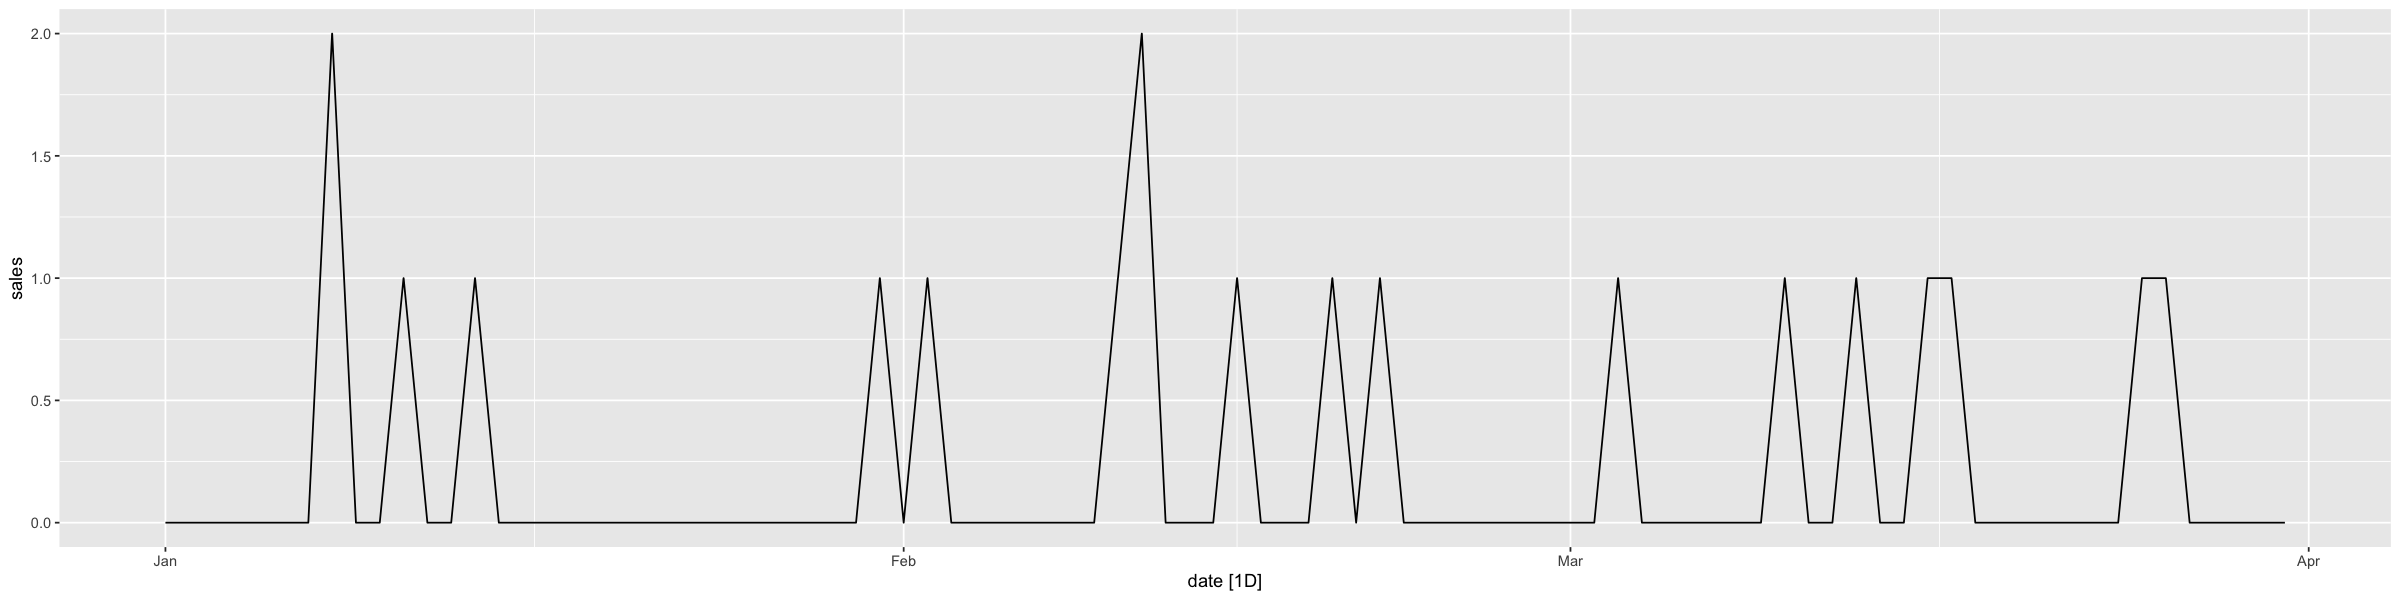

In [10]:
ts_final_train_features %>%
    filter(id == "FOODS_3_001") %>%
    filter(year(date) == "2013") %>%
    filter(quarter(date) == 1) %>%
    autoplot(sales)

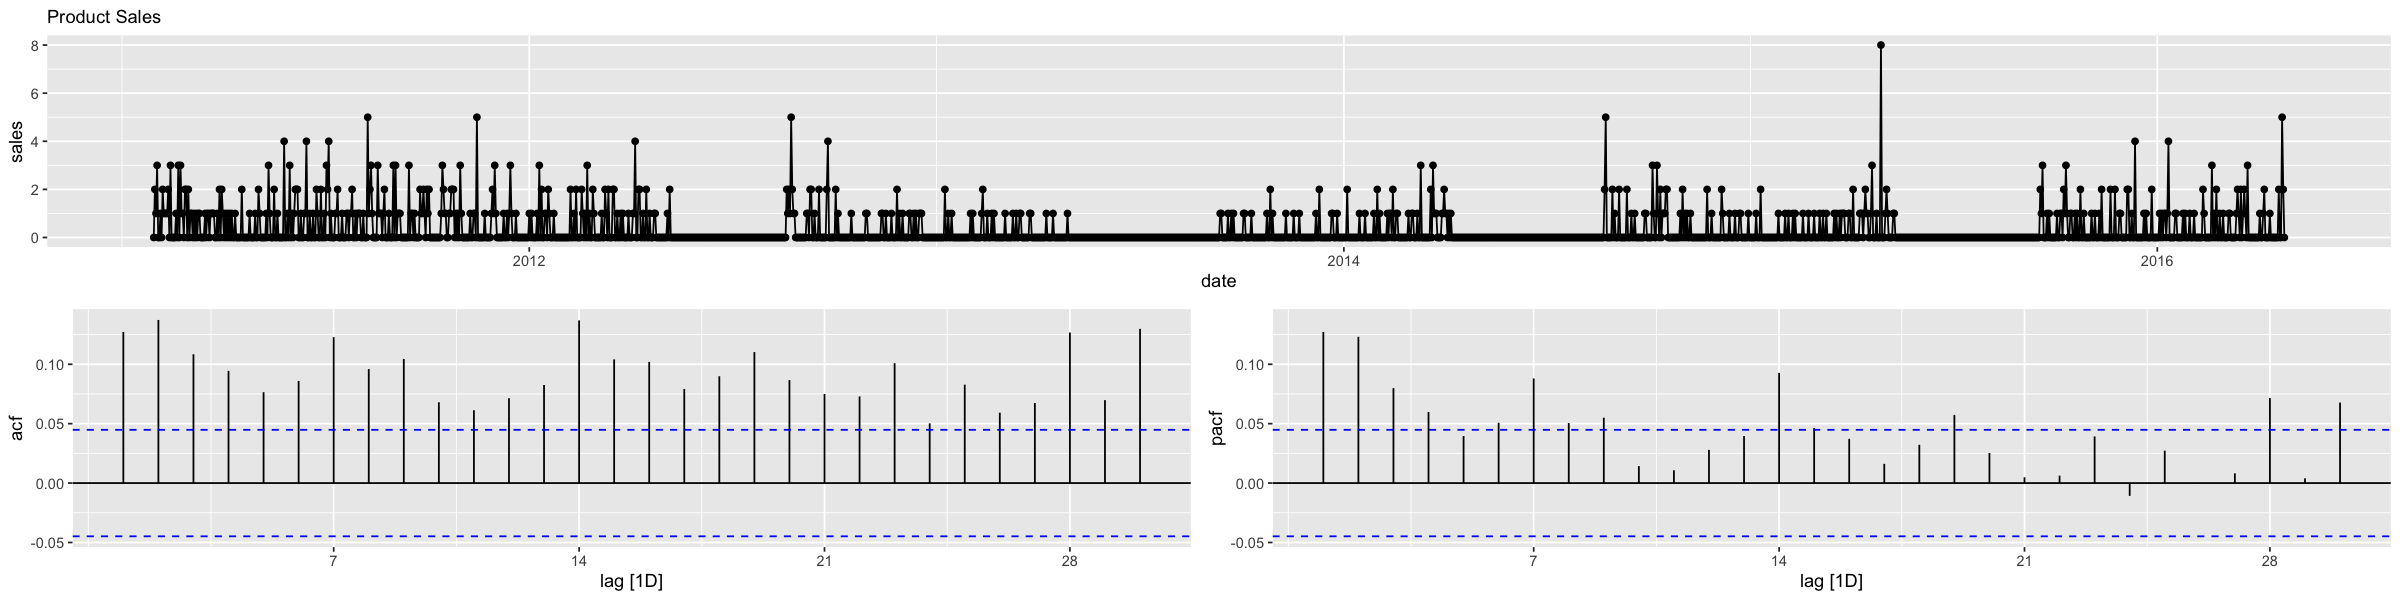

In [11]:
ts_final_train_features %>%
    filter(id == "FOODS_3_001") %>%
    gg_tsdisplay(sales, plot_type='partial', lag=30) +
    labs(subtitle = "Product Sales")

Clearly, sales time series data is not staionary. We could observe clear seasonalities in the ACF plot. This suggests some differencing. 

In [12]:
ts_final_train_features %>%
    filter(id == "FOODS_3_001") %>%
    features(sales, unitroot_kpss)

id,kpss_stat,kpss_pvalue
<chr>,<dbl>,<dbl>
FOODS_3_001,2.543194,0.01


In [13]:
ts_final_train_features %>%
    filter(id == "FOODS_3_001") %>%
    features(sales, unitroot_ndiffs)

id,ndiffs
<chr>,<int>
FOODS_3_001,1


unitroot_ndiffs suggest that we use one order differencing.

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


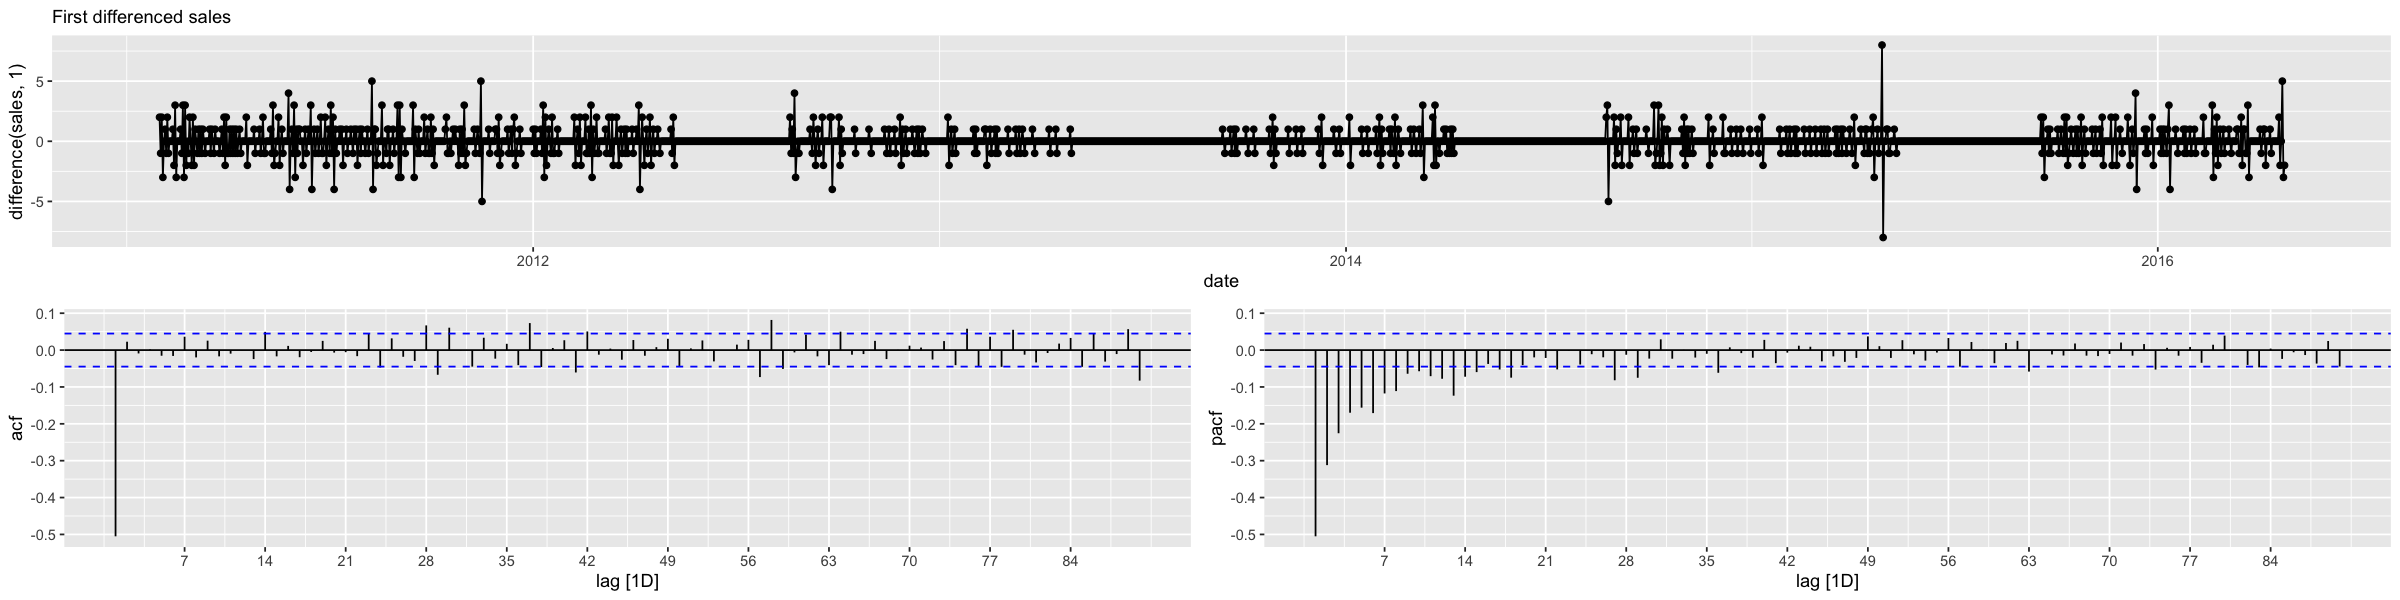

In [14]:
ts_final_train_features %>%
    filter(id == "FOODS_3_001") %>%
    gg_tsdisplay(difference(sales, 1), plot_type='partial', lag_max=90) +
    labs(subtitle = "First differenced sales")

Warning message:
“Removed 31 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 31 rows containing missing values (`geom_point()`).”


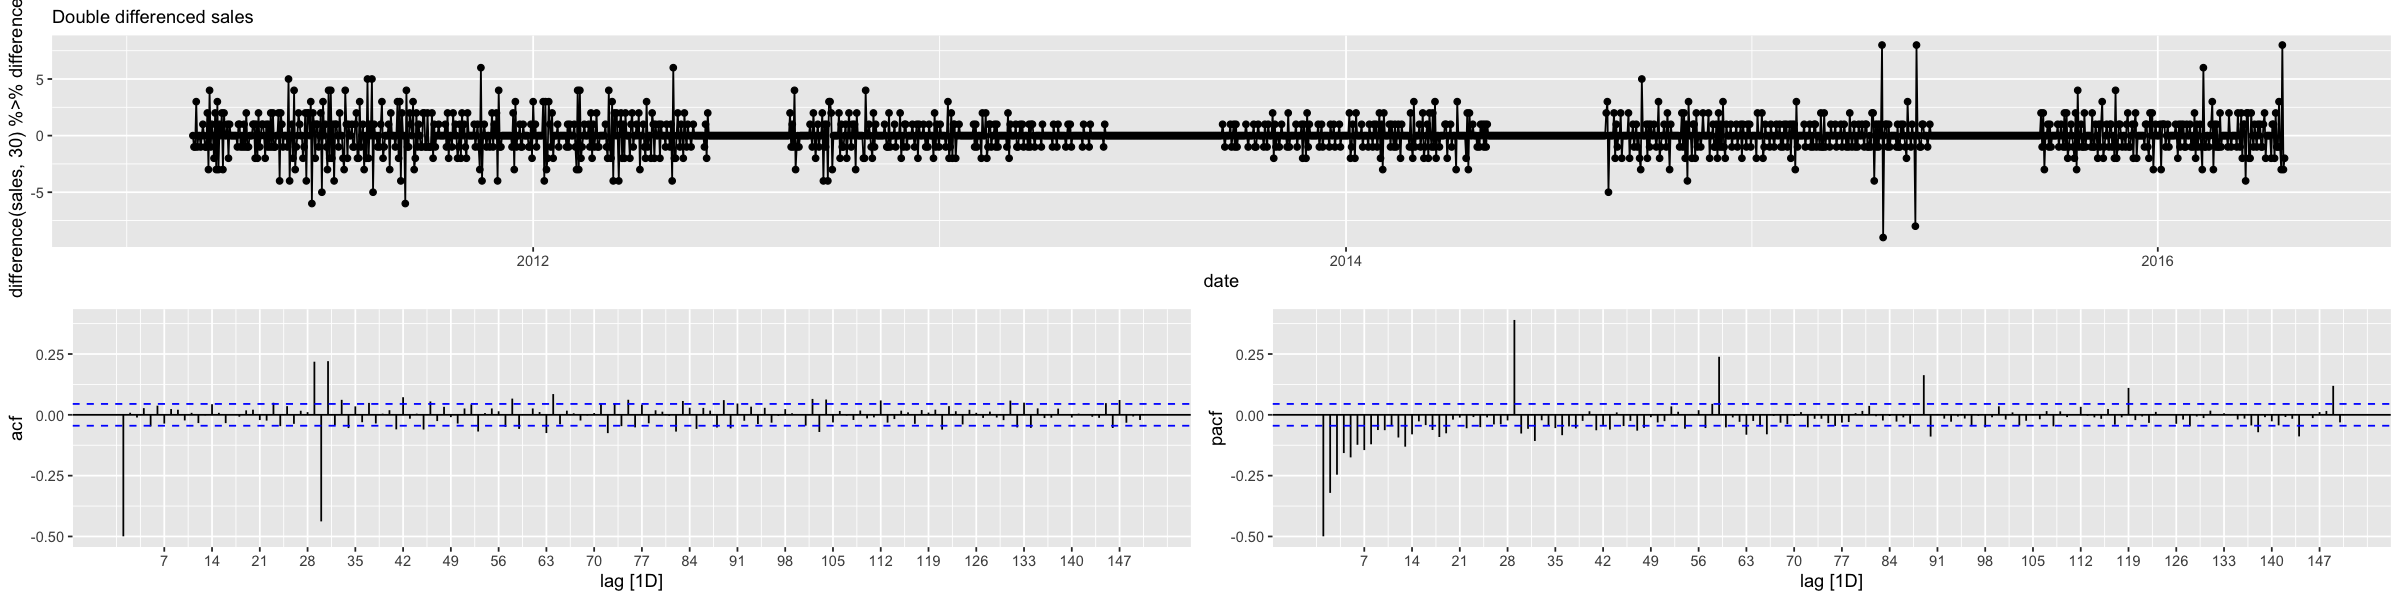

In [15]:
ts_final_train_features %>%
    filter(id == "FOODS_3_001") %>%
    gg_tsdisplay(difference(sales,30) %>% difference(), plot_type='partial', lag_max=150) +
    labs(subtitle = "Double differenced sales")

The significant spike at lag 1 in the ACF suggests a non-seasonal MA(1) component. The significant spike at lag 30 in the ACF suggests a seasonal MA(1) component. Consequently, we begin with an ARIMA(0,1,1)(0,1,1)_30 model, indicating a first difference, a seasonal difference with 30 days, and non-seasonal MA(1) and seasonal MA(30) component.

## Pure SARIMA

In [16]:
products = c("FOODS_3_001","FOODS_3_002","FOODS_3_003","FOODS_3_004","FOODS_3_005")

In [17]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales, stepwise = TRUE, approx = TRUE)
  )
arima_fit

id,auto
<chr>,<model>
FOODS_3_001,"<ARIMA(2,1,2)(2,0,0)[7]>"
FOODS_3_002,"<ARIMA(1,1,2)(0,0,2)[7]>"
FOODS_3_003,"<ARIMA(1,1,2)>"
FOODS_3_004,"<ARIMA(3,1,2)(0,0,1)[7]>"
FOODS_3_005,"<ARIMA(1,1,2)(1,0,2)[7]>"


In [18]:
glance(arima_fit) %>% arrange(AICc) %>% select(id:BIC)

id,.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOODS_3_004,auto,0.1150357,-644.4719,1302.944,1303.003,1341.835
FOODS_3_003,auto,0.1409645,-839.1452,1686.290,1686.311,1708.514
FOODS_3_001,auto,0.4894544,-2028.3734,4070.747,4070.806,4109.638
FOODS_3_005,auto,0.9124045,-2623.4379,5260.876,5260.935,5299.767
FOODS_3_002,auto,1.0502964,-2758.2526,5528.505,5528.549,5561.841


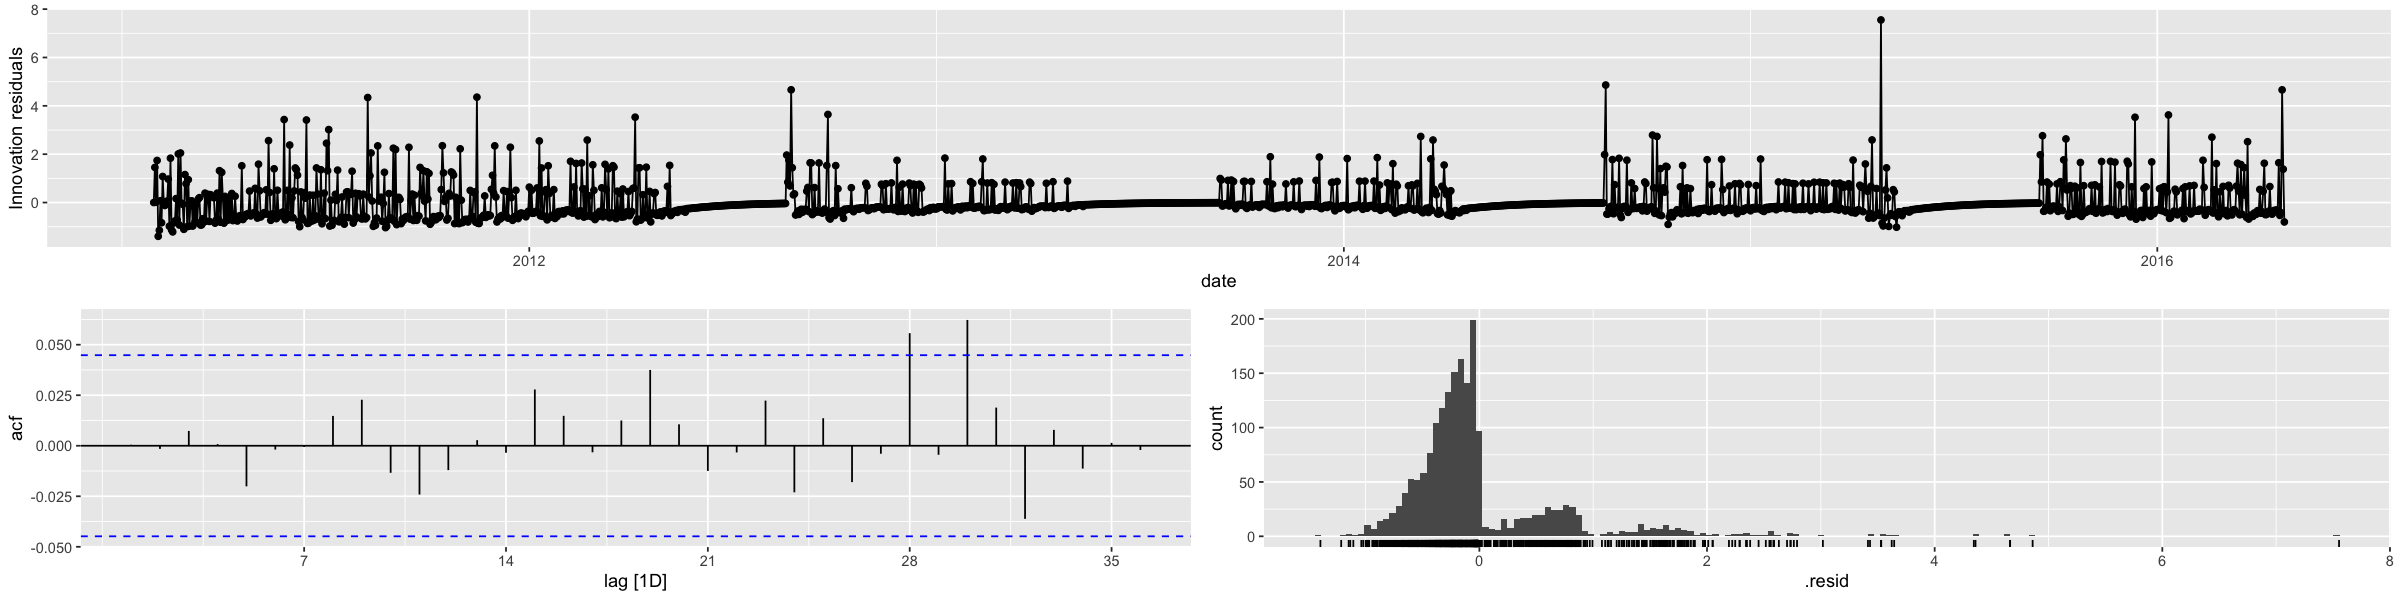

In [19]:
arima_fit %>% filter(id %in% c("FOODS_3_001")) %>% gg_tsresiduals(lag_max=36)

In [20]:
augment(arima_fit) %>%
  features(.innov, ljung_box, lag = 10)

id,.model,lb_stat,lb_pvalue
<chr>,<chr>,<dbl>,<dbl>
FOODS_3_001,auto,2.651336,9.884821e-01
FOODS_3_002,auto,7.273752,6.993730e-01
FOODS_3_003,auto,44.402566,2.786406e-06
FOODS_3_004,auto,17.586196,6.235822e-02
FOODS_3_005,auto,10.769170,3.757824e-01


Portmauteaux test indicate residuals is whitenoise.

In [21]:
arima_fc = arima_fit %>%
    forecast(h = 28)
head(arima_fc)

id,.model,date,sales,.mean
<chr>,<chr>,<date>,<dist>,<dbl>
FOODS_3_001,auto,2016-04-25,"N(0.7, 0.49)",0.7004551
FOODS_3_001,auto,2016-04-26,"N(0.61, 0.49)",0.6098297
FOODS_3_001,auto,2016-04-27,"N(0.51, 0.49)",0.5059478
FOODS_3_001,auto,2016-04-28,"N(0.49, 0.5)",0.4941290
FOODS_3_001,auto,2016-04-29,"N(0.7, 0.5)",0.7034286
FOODS_3_001,auto,2016-04-30,"N(0.57, 0.5)",0.5719119


In [22]:
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima

.model,id,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
auto,FOODS_3_001,Test,-0.13775481,0.8406781,0.6331973,-Inf,Inf,NaN,NaN,-0.02052882
auto,FOODS_3_002,Test,0.85596208,1.4961475,1.0075064,-Inf,Inf,NaN,NaN,0.12360871
auto,FOODS_3_003,Test,0.27378209,0.8453007,0.7193834,-Inf,Inf,NaN,NaN,-0.13015908
auto,FOODS_3_004,Test,0.04253151,0.3868583,0.2671166,-Inf,Inf,NaN,NaN,0.02937260
auto,FOODS_3_005,Test,1.08889359,1.6685661,1.3050862,-Inf,Inf,NaN,NaN,0.07460488


In [23]:
accuracy_arima$RMSE %>% mean()

[1] 1.04751

## ARIMA with regressors

### sell_price good?

In [24]:
arima_residuals = augment(arima_fit) %>%
    filter(id %in% c("FOODS_3_001")) %>%
    select(.innov)
head(arima_residuals)

.innov,date
<dbl>,<date>
0.00000000,2011-01-29
1.45324419,2011-01-30
0.01352715,2011-01-31
1.74055460,2011-02-01
-1.39660637,2011-02-02
-1.14845653,2011-02-03


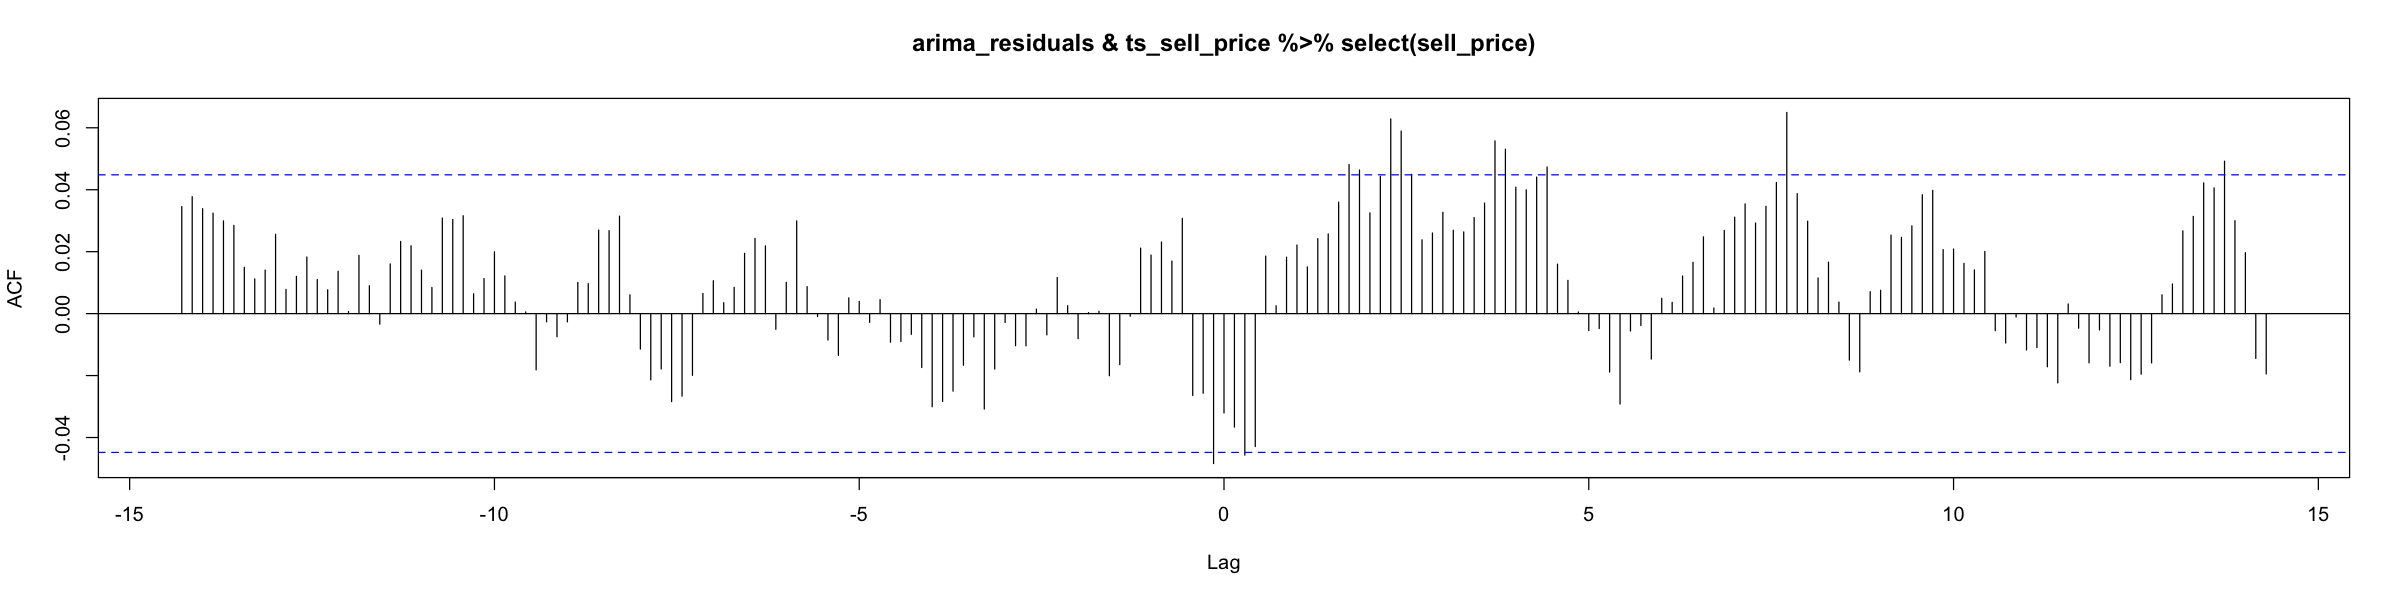

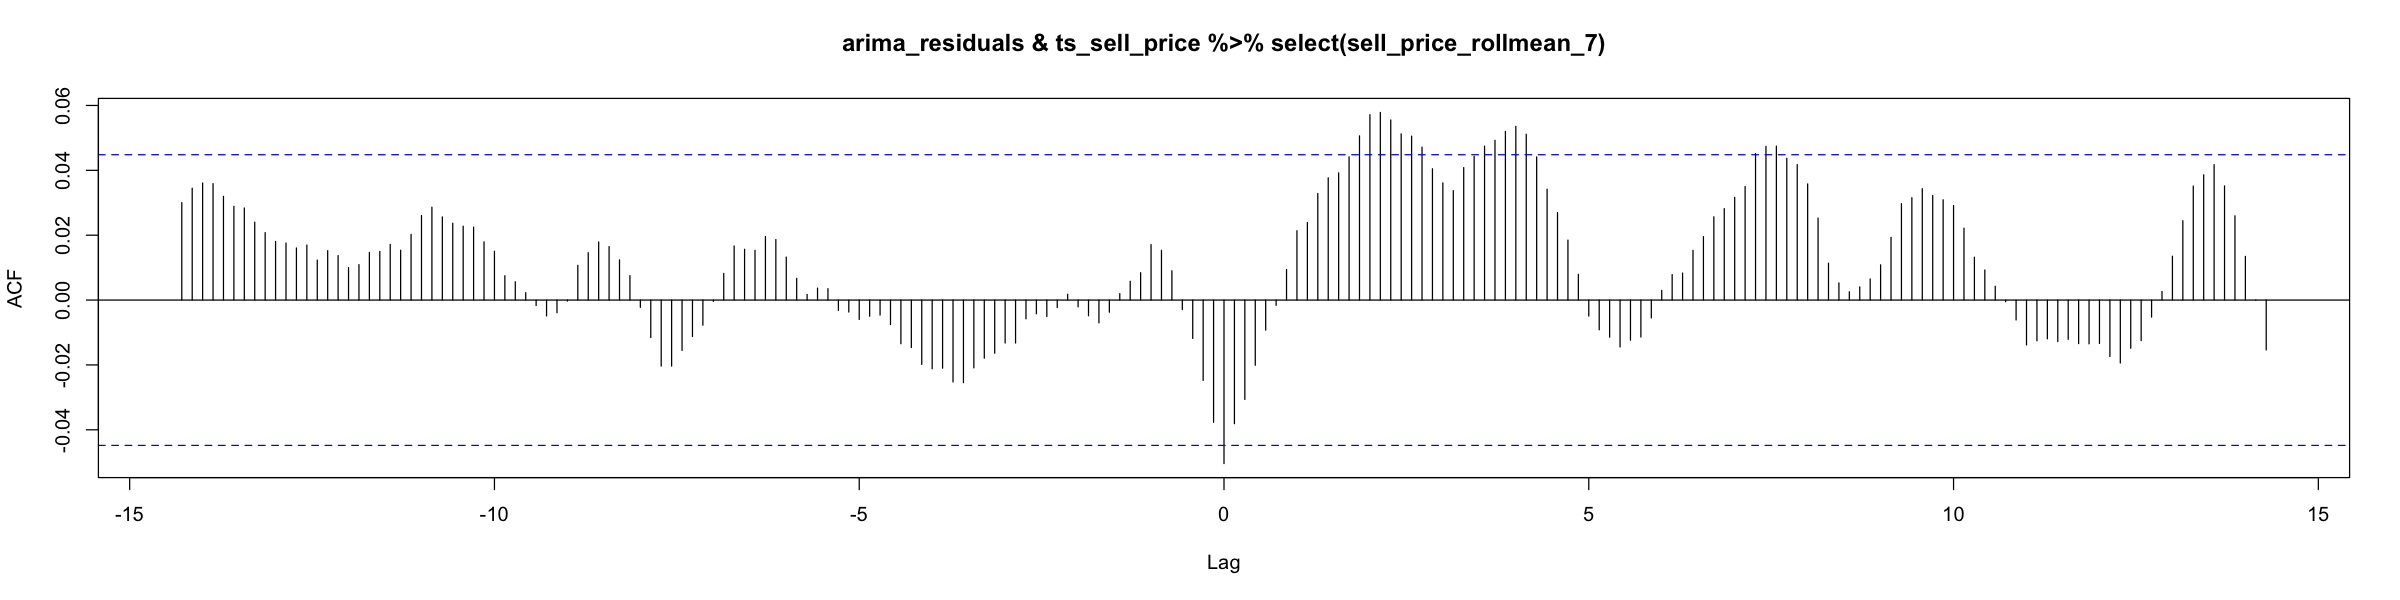

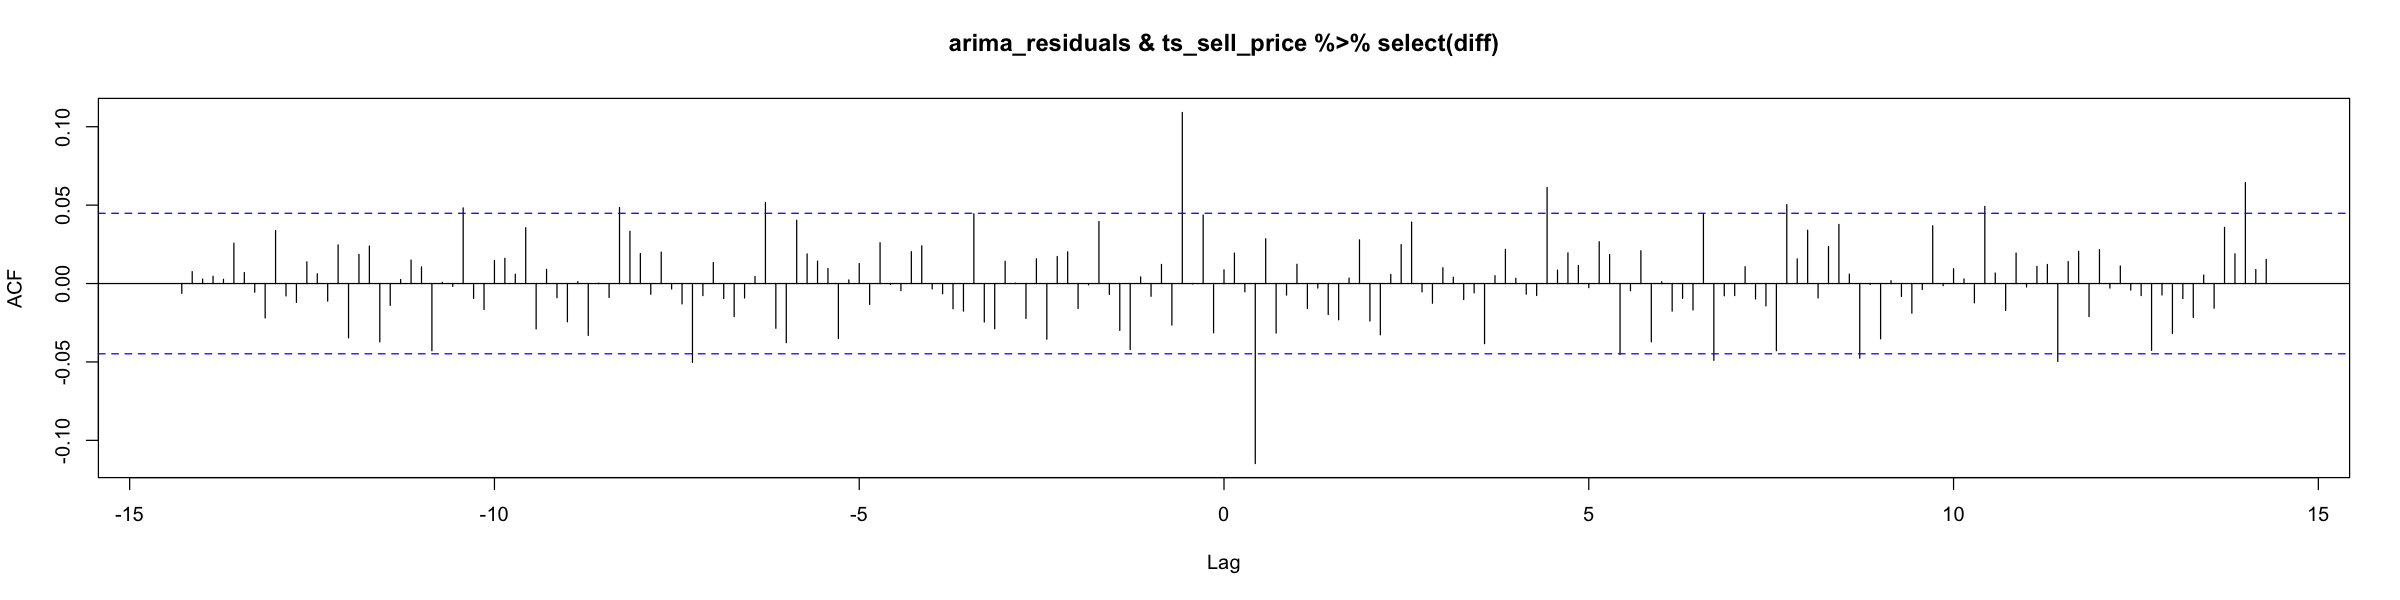

In [25]:
ts_sell_price = ts_final_train_features %>%
    filter(id %in% c("FOODS_3_001")) %>%
    select(date, sell_price, sell_price_rollmean_7)
ts_sell_price = mutate(ts_sell_price, diff = difference(sell_price, order_by = date))
ts_sell_price[is.na(ts_sell_price)] = 0
ccf(arima_residuals, ts_sell_price %>% select(sell_price), 100)
ccf(arima_residuals, ts_sell_price %>% select(sell_price_rollmean_7), 100)
ccf(arima_residuals, ts_sell_price %>% select(diff), 100)

### sell_price

In [26]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ sell_price, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.053437

In [27]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ sell_price_rollmean_7, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.083463

In [28]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ price_change, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.053443

### Interventional event

In [29]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ has_event, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


[1] 1.048476

In [30]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ has_event_near, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.046824

In [31]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ has_two_events, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.042094

In [32]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ snap_TX, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.026502

### weekend, day of week

In [33]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ weekend, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.048644

In [34]:
colnames(ts_final_train_features) 
colnames(ts_final_test_features) 

[1] "id"                    "date"                  "sales"                
 [4] "wday"                  "month"                 "month_day"            
 [7] "year_day"              "weekend"               "has_event"            
[10] "has_two_events"        "has_event_near"        "price_change"         
[13] "sell_price"            "sell_price_rollmean_7" "snap_TX"              
[16] "Q1"                    "Q2"                    "Q3"                   
[19] "Q4"                    "cluster"               "quarter"              
[22] "wday_2"                "wday_3"                "wday_4"               
[25] "wday_5"                "wday_6"                "wday_7"               
[28] "quarter_2"             "quarter_3"             "quarter_4"            
[31] "month_2"               "month_3"               "month_4"              
[34] "month_5"               "month_6"               "month_7"              
[37] "month_8"               "month_9"               "month_10"             
[40] "month_11"              "month_12"

[1] "id"                    "date"                  "sales"                
 [4] "wday"                  "month"                 "month_day"            
 [7] "year_day"              "weekend"               "has_event"            
[10] "has_two_events"        "has_event_near"        "price_change"         
[13] "sell_price"            "sell_price_rollmean_7" "snap_TX"              
[16] "Q1"                    "Q2"                    "Q3"                   
[19] "Q4"                    "cluster"               "quarter"              
[22] "wday_2"                "wday_3"                "wday_4"               
[25] "wday_5"                "wday_6"                "wday_7"               
[28] "quarter_2"             "quarter_3"             "quarter_4"            
[31] "month_2"               "month_3"               "month_4"              
[34] "month_5"               "month_6"               "month_7"              
[37] "month_8"               "month_9"               "month_10"             
[40] "month_11"              "month_12"

In [35]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ wday_2 + wday_3 + wday_4 + wday_5 + wday_6 + wday_7, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.053238

In [36]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ quarter_2 + quarter_3 + quarter_4, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.041305

In [37]:
arima_fit <- ts_final_train_features %>%
  filter(id %in% products) %>%
  model(
    auto = ARIMA(sales ~ month_2 + month_3 + month_4 + month_5 + month_6 + month_7+ month_8+ month_9+ month_10+ month_11 + month_12, stepwise = TRUE, approx = TRUE)
  )

ts_final_test_features_product = ts_final_test_features %>% 
       filter(id %in% products)
arima_fc = arima_fit %>% forecast(ts_final_test_features_product)
accuracy_arima = accuracy(arima_fc, ts_final_test_features)
accuracy_arima$RMSE %>% mean()

[1] 1.03669